In [1]:
import pickle as pkl
import time
import os
import numpy as np
import sys
#from music21 import instrument, note, stream, chord, duration
#from models.RNNAttention import create_network, sample_with_temp

import matplotlib.pyplot as plt

from keras.preprocessing.text import Tokenizer

from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.utils import plot_model
from keras.utils import np_utils
from keras.layers import LSTM, Input, Dropout, Dense, Activation, Embedding, Concatenate, Reshape
from keras.layers import Flatten, RepeatVector, Permute, TimeDistributed
from keras.layers import Multiply, Lambda, Softmax
import keras.backend as K 
from keras.models import Model
from keras.optimizers import RMSprop

Using TensorFlow backend.


# parameters

In [2]:
# run params
section = 'composetxt'
run_id = '0001'
txt_name = 'txtattn'

run_folder = 'run/{}/'.format(section)
run_folder += '_'.join([run_id, txt_name])

# model params
embed_size = 100
rnn_units = 256
use_attention = True

## load the lookup tables

In [3]:

store_folder = os.path.join(run_folder, 'store')


## build the model

In [4]:
def create_network(n_tokens, embed_size = 100, rnn_units = 256, use_attention = False):
    """ create the structure of the neural network """

    text_in = Input(shape = (None,))

    x1 = Embedding(n_tokens, embed_size)(text_in) 

    #x = Concatenate()([x1,x2])
    x = x1 # todo: remove and change x1

    x = LSTM(rnn_units, return_sequences=True)(x)
    # x = Dropout(0.2)(x)

    if use_attention:

        x = LSTM(rnn_units, return_sequences=True)(x)
        # x = Dropout(0.2)(x)

        e = Dense(1, activation='tanh')(x)
        e = Reshape([-1])(e)
        alpha = Activation('softmax')(e)

        alpha_repeated = Permute([2, 1])(RepeatVector(rnn_units)(alpha)) # todo: check the 2, 1

        c = Multiply()([x, alpha_repeated])
        c = Lambda(lambda xin: K.sum(xin, axis=1), output_shape=(rnn_units,))(c)
    
    else:
        c = LSTM(rnn_units)(x)
        # c = Dropout(0.2)(c)
                                    
    text_out = Dense(n_tokens, activation = 'softmax', name = 'text')(c)
   
    model = Model([text_in], [text_out])

    if use_attention:
        att_model = Model([text_in], alpha)
    else:
        att_model = None

    opti = RMSprop(lr = 0.001)
    model.compile(loss=['categorical_crossentropy'], optimizer=opti)

    return model, att_model

In [5]:
import re

token_type = 'word'

#load in the text and perform some cleanup

seq_length = 20

filename = "./data/aesop/data.txt"

with open(filename, encoding='utf-8-sig') as f:
    text = f.read()    
    
#removing text before and after the main stories
start = text.find("THE FOX AND THE GRAPES\n\n\n")
end = text.find("ILLUSTRATIONS\n\n\n[")
text = text[start:end]

start_story = '| ' * seq_length
    
text = start_story + text
text = text.lower()
text = text.replace('\n\n\n\n\n', start_story)
text = text.replace('\n', ' ')
text = re.sub('  +', '. ', text).strip()
text = text.replace('..', '.')

text = re.sub('([!"#$%&()*+,-./:;<=>?@[\]^_`{|}~])', r' \1 ', text)
text = re.sub('\s{2,}', ' ', text)

len(text)

213694

In [6]:
from keras.preprocessing.text import Tokenizer

if token_type == 'word':
    tokenizer = Tokenizer(char_level = False, filters = '')
else:
    tokenizer = Tokenizer(char_level = True, filters = '', lower = False)    
    
tokenizer.fit_on_texts([text])

total_words = len(tokenizer.word_index) + 1

token_list = tokenizer.texts_to_sequences([text])[0]

print(total_words)

print(str(tokenizer.word_index)[0:50]) # vocabulary
print(token_list[:50]) # tokenized text

4170
{'|': 1, ',': 2, 'the': 3, 'and': 4, '.': 5, 'a': 
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 56, 4, 3, 940, 5, 6, 382, 56, 94, 77, 216, 1557, 9, 940, 941, 62, 6, 581, 20, 12, 2226, 162, 6, 359, 2227, 2, 4, 158, 11]


In [7]:
weights_folder = os.path.join(run_folder, 'weights')
weights_file = 'weights.h5'

#model, att_model = create_network(n_notes, n_durations, embed_size, rnn_units, use_attention)
model, att_model = create_network(len(tokenizer.word_index)+1, embed_size, rnn_units, use_attention)

# Load the weights to each node
weight_source = os.path.join(weights_folder,weights_file)
model.load_weights(weight_source)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, None, 100)    417000      input_1[0][0]                    
__________________________________________________________________________________________________
lstm_1 (LSTM)                   (None, None, 256)    365568      embedding_1[0][0]                
__________________________________________________________________________________________________
lstm_2 (LSTM)                   (None, None, 256)    525312      lstm_1[0][0]                     
____________________________________________________________________________________________

## build your own phrase

In [11]:
# prediction params
text_temp=0.5
max_extra_text = 150 # 50
max_seq_len = 32
seq_len = 32

# notes = ['START', 'D3', 'D3', 'E3', 'D3', 'G3', 'F#3','D3', 'D3', 'E3', 'D3', 'G3', 'F#3','D3', 'D3', 'E3', 'D3', 'G3', 'F#3','D3', 'D3', 'E3', 'D3', 'G3', 'F#3']
# durations = [0, 0.75, 0.25, 1, 1, 1, 2, 0.75, 0.25, 1, 1, 1, 2, 0.75, 0.25, 1, 1, 1, 2, 0.75, 0.25, 1, 1, 1, 2]

# init text and translate input text to tokens
text_init = ['START', 'this', 'is', 'a', 'first', 'test']
token_seq = tokenizer.texts_to_sequences([text_init])[0] # todo: what if new tokens in init sequence?

if seq_len is not None:
    text_init = ['START'] * (seq_len - len(token_seq)) + token_seq

sequence_length = len(text_init)

print(token_seq)

[1076, 74, 42, 6, 185, 1819]


## Generate text from the neural network based on a sequence of words

We will generate tokens and translate the tokens back to words after generation

In [11]:
import tensorflow as tf

prediction_output = []
text_input_sequence = []

overall_preds = []

#for n, d in zip(notes, durations):
for n in text_init:
    text_int = text_to_int[n]
    
    text_input_sequence.append(text_int)
    prediction_output.append([n, d])
    
    if n != 'START':
        new_text = np.zeros(128)
        new_text[midi_note.pitch.midi] = 1 # ??????????????
        overall_preds.append(new_text)

att_matrix = np.zeros(shape = (max_extra_text+sequence_length, max_extra_text))

for note_index in range(max_extra_text):

    prediction_input = [
        np.array([text_input_sequence]) # todo: cleanup concatenate from notes,duration to just tokens
       ]
    
    gpus = tf.config.experimental.list_physical_devices('GPU') # added from https://stackoverflow.com/questions/57062456/function-call-stack-keras-scratch-graph-error
    if gpus:
        try:
            # Restrict TensorFlow to only use the fourth GPU
            tf.config.experimental.set_visible_devices(gpus[0], 'GPU')

            # Currently, memory growth needs to be the same across GPUs
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
            logical_gpus = tf.config.experimental.list_logical_devices('GPU')
            print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
        except RuntimeError as e:
            # Memory growth must be set before GPUs have been initialized
            print(e)

    notes_prediction = model.predict(prediction_input, verbose=0)
    if use_attention:
        att_prediction = att_model.predict(prediction_input, verbose=0)[0]
        att_matrix[(note_index-len(att_prediction)+sequence_length):(note_index+sequence_length), note_index] = att_prediction
    
    new_text = np.zeros(128)
    
    for idx, n_i in enumerate(text_prediction[0]):
        try:
            note_name = int_to_text[idx] # todo: tokens !!!!!!!!!!
            midi_note = note.Note(note_name)
            new_note[midi_note.pitch.midi] = n_i
        except:
            pass
        
    overall_preds.append(new_text)
    
    i1 = sample_with_temp(notes_prediction[0], notes_temp)
    
    note_result = int_to_note[i1]
    
    prediction_output.append([note_result, duration_result])

    notes_input_sequence.append(i1)
    
    if len(notes_input_sequence) > max_seq_len:
        notes_input_sequence = notes_input_sequence[1:]
        
#     print(note_result)
#     print(duration_result)
        
    if text_result == 'START':
        break

overall_preds = np.transpose(np.array(overall_preds)) 
print('Generated sequence of {} notes'.format(len(prediction_output)))

Physical devices cannot be modified after being initialized
Physical devices cannot be modified after being initialized
Physical devices cannot be modified after being initialized
Physical devices cannot be modified after being initialized
Physical devices cannot be modified after being initialized
Physical devices cannot be modified after being initialized
Physical devices cannot be modified after being initialized
Physical devices cannot be modified after being initialized
Physical devices cannot be modified after being initialized
Physical devices cannot be modified after being initialized
Physical devices cannot be modified after being initialized
Physical devices cannot be modified after being initialized
Physical devices cannot be modified after being initialized
Physical devices cannot be modified after being initialized
Physical devices cannot be modified after being initialized
Physical devices cannot be modified after being initialized
Physical devices cannot be modified afte

Physical devices cannot be modified after being initialized
Physical devices cannot be modified after being initialized
Physical devices cannot be modified after being initialized
Physical devices cannot be modified after being initialized
Physical devices cannot be modified after being initialized
Physical devices cannot be modified after being initialized
Physical devices cannot be modified after being initialized
Physical devices cannot be modified after being initialized
Physical devices cannot be modified after being initialized
Physical devices cannot be modified after being initialized
Generated sequence of 182 notes


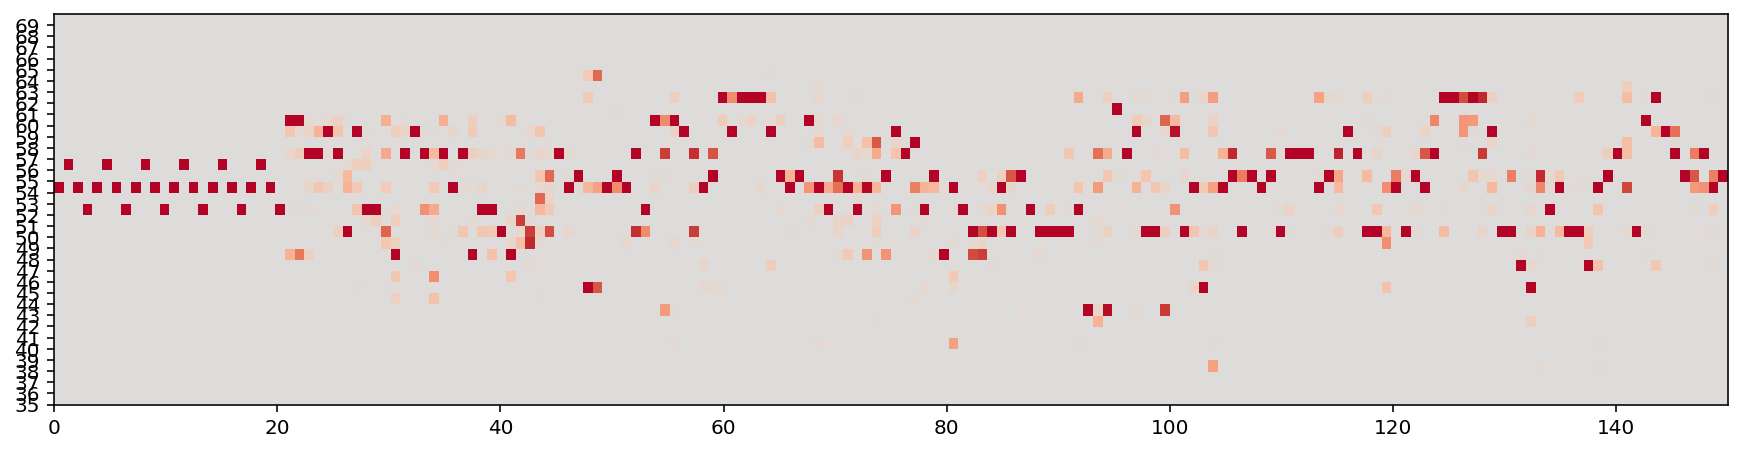

In [12]:
fig, ax = plt.subplots(figsize=(15,15))
ax.set_yticks([int(j) for j in range(35,70)])

plt.imshow(overall_preds[35:70,:], origin="lower", cmap='coolwarm', vmin = -0.5, vmax = 0.5, extent=[0, max_extra_notes, 35,70]
          
          )

## convert the output from the prediction from tokens to words

In [13]:
output_folder = os.path.join(run_folder, 'output')

# create note and chord objects based on the values generated by the model
for pattern in prediction_output:
    note_pattern, duration_pattern = pattern
    # pattern is a chord
    if ('.' in note_pattern):
        notes_in_chord = note_pattern.split('.')
        chord_notes = []
        for current_note in notes_in_chord:
            new_note = note.Note(current_note)
            new_note.duration = duration.Duration(duration_pattern)
            new_note.storedInstrument = instrument.Violoncello()
            chord_notes.append(new_note)
        new_chord = chord.Chord(chord_notes)
        midi_stream.append(new_chord)
    elif note_pattern == 'rest':
    # pattern is a rest
        new_note = note.Rest()
        new_note.duration = duration.Duration(duration_pattern)
        new_note.storedInstrument = instrument.Violoncello()
        midi_stream.append(new_note)
    elif note_pattern != 'START':
    # pattern is a note
        new_note = note.Note(note_pattern)
        new_note.duration = duration.Duration(duration_pattern)
        new_note.storedInstrument = instrument.Violoncello()
        midi_stream.append(new_note)


timestr = time.strftime("%Y%m%d-%H%M%S")
midi_stream.write('midi', fp=os.path.join(output_folder, 'output-' + timestr + '.mid'))

'run/compose/0006_cello\\output\\output-20200511-144016.mid'

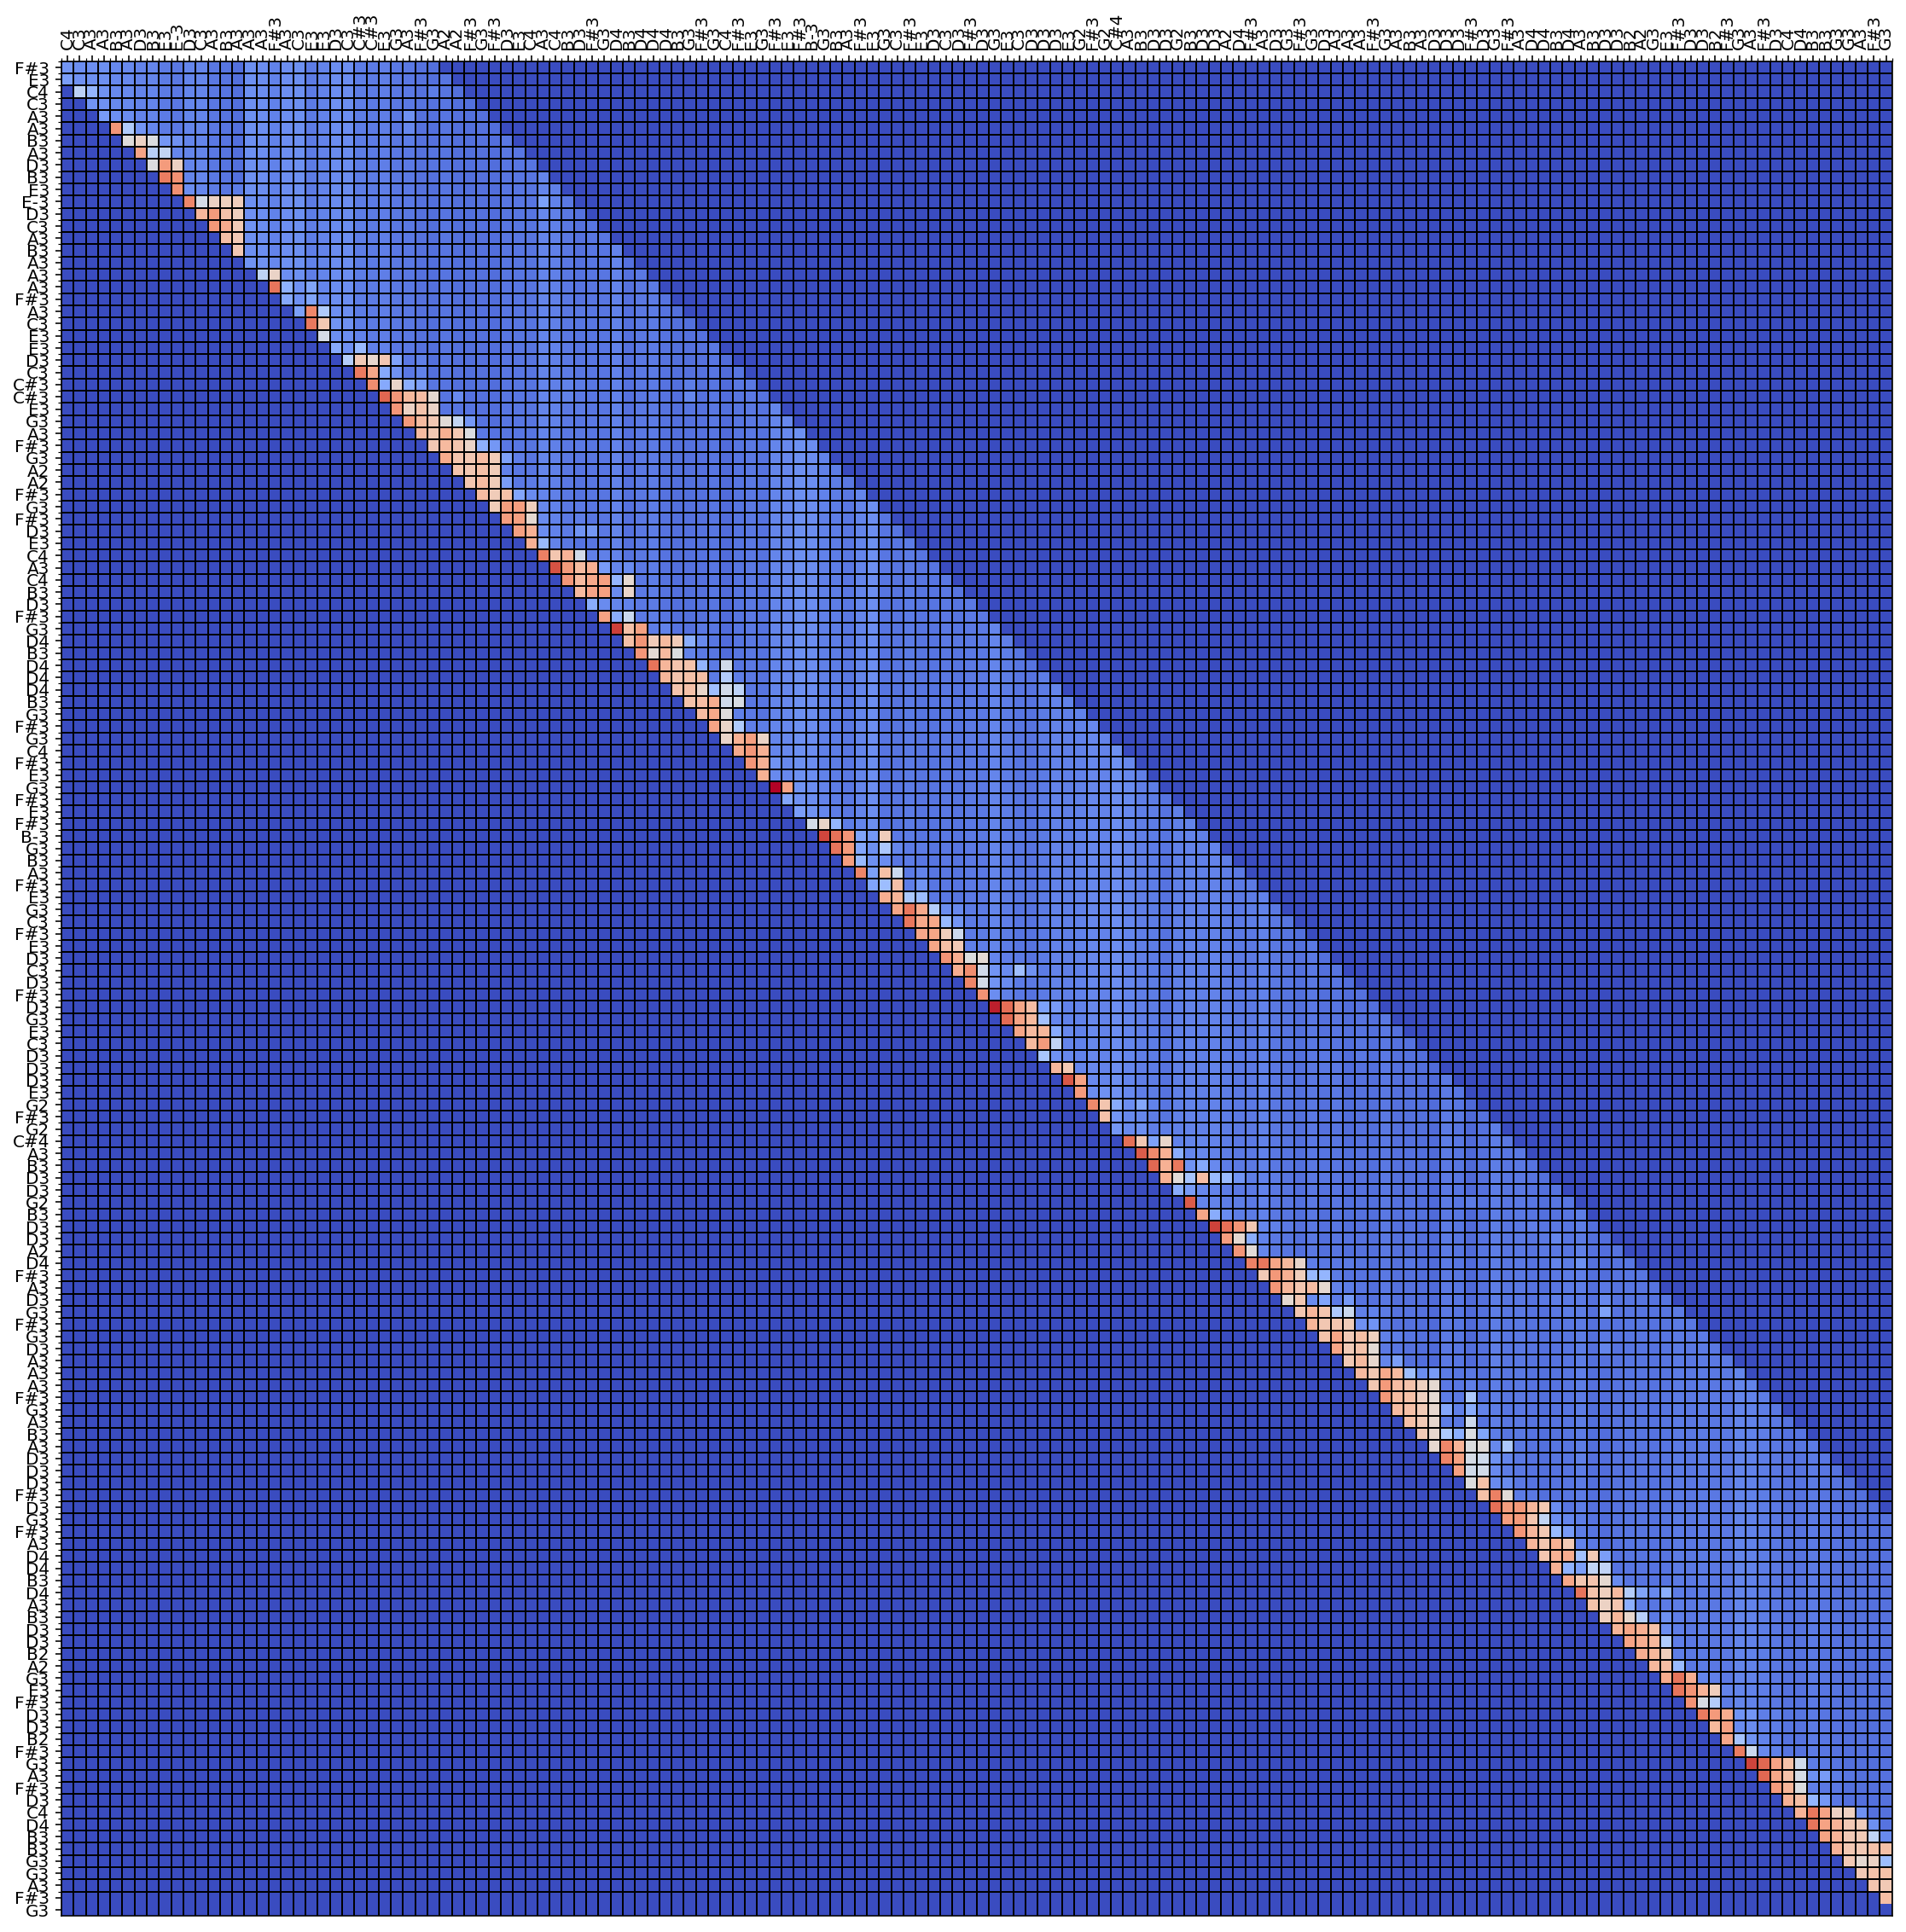

In [14]:
## attention plot
if use_attention:
    fig, ax = plt.subplots(figsize=(20,20))

    im = ax.imshow(att_matrix[(seq_len-2):,], cmap='coolwarm', interpolation='nearest')
    

    # Minor ticks
    ax.set_xticks(np.arange(-.5, len(prediction_output)- seq_len, 1), minor=True);
    ax.set_yticks(np.arange(-.5, len(prediction_output)- seq_len, 1), minor=True);

    # Gridlines based on minor ticks
    ax.grid(which='minor', color='black', linestyle='-', linewidth=1)  
    
    
    # We want to show all ticks...
    ax.set_xticks(np.arange(len(prediction_output) - seq_len))
    ax.set_yticks(np.arange(len(prediction_output)- seq_len+2))
    # ... and label them with the respective list entries
    ax.set_xticklabels([n[0] for n in prediction_output[(seq_len):]])
    ax.set_yticklabels([n[0] for n in prediction_output[(seq_len - 2):]])

    # ax.grid(color='black', linestyle='-', linewidth=1)

    ax.xaxis.tick_top()

    
    plt.setp(ax.get_xticklabels(), rotation=90, ha="left", va = "center",
             rotation_mode="anchor")

    plt.show()